(sec:othello-agent)=
# オセロAIの作成

ここからは、より高度な強化学習の対象としてオセロを取り扱う。ご存じの通り、オセロは(諸説あるものの)日本で発祥した「はさみ碁」の一種で、白と黒のディスクを8×8の盤の上に並べ、同色で挟まれたディスクを裏返すことで、より多くのマスを獲得した方が勝利するというゲームである。

:::{admonition} オセロとリバーシ
:class: note

オセロは日本以外ではリバーシのように呼ばれることがある。リバーシは初期状態として、ディスクが置かれていない状態からスタートするが、オセロは盤の中央に白黒2枚ずつのディスクを置いた状態からスタートする、という違いがある。

- 参考: [オセロ（ボードゲーム）- Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%AA%E3%82%BB%E3%83%AD_(%E3%83%9C%E3%83%BC%E3%83%89%E3%82%B2%E3%83%BC%E3%83%A0))

:::

In [1]:
"""
Google Colab用の準備
"""

IN_COLAB = True
try:
    import google.colab

    print("You are running the code in Google Colab.")
except ImportError:
    IN_COLAB = False
    print("You are running the code on the local computer.")

if IN_COLAB:
    # othelloモジュールのインストール
    !pip install git+https://github.com/tatsy-classes/cothello.git@v2.1.0

You are running the code on the local computer.


In [ ]:
import time
import random
import contextlib
import multiprocessing as mp

import numpy as np
import seaborn as sns
import IPython.display as display
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from matplotlib.animation import ArtistAnimation

try:
    from myst_nb import glue
except ImportError:
    glue = lambda *args, **kwargs: None

rc = {"figure.dpi": 150}
sns.set_theme(style="white", rc=rc)

# 乱数シードの固定
random.seed(12345)
np.random.seed(12345)

# 実験に用いるエピソード数
n_episodes = 100
glue("n_episodes", n_episodes)

# 並列化スレッド数
n_jobs = min(4, mp.cpu_count())

100

In [ ]:
@contextlib.contextmanager
def tqdm_joblib(total, callback=None, **kwargs):
    import joblib

    progress_bar = tqdm(total=total, smoothing=0, **kwargs)

    class TqdmBatchCompletionCallBack(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, out):
            super(TqdmBatchCompletionCallBack, self).__call__(out)
            with self.parallel._lock:
                if callback is not None:
                    if hasattr(self, "_result"):
                        for r in self._result:
                            callback(progress_bar, *r)
                progress_bar.update(n=self.batch_size)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallBack

    try:
        yield progress_bar
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        progress_bar.close()

In [ ]:
import othello
from othello import Player

b_win = 0
w_win = 0
draw = 0


def check(p1_fn, p2_fn):
    global b_win, w_win, draw
    b_win = 0
    w_win = 0
    draw = 0

    def game(p1_fn, p2_fn):
        # ゲームのリセット
        env = othello.make()
        env.reset()

        # 手番を決定
        first_is_p1 = np.random.random() < 0.5
        if not first_is_p1:
            p1_fn, p2_fn = p2_fn, p1_fn

        # エピソード開始
        while not env.is_done():
            # 有効手の列挙
            actions = env.legal_actions()

            # 手番のプレイヤーによる行動の選択
            if env.player.is_black():
                action = p1_fn(env)
            else:
                action = p2_fn(env)

            # 着手による盤の状態の更新
            env.update(action)

        n_black = env.count(Player.BLACK)
        n_white = env.count(Player.WHITE)

        if not first_is_p1:
            n_black, n_white = n_white, n_black

        return n_black, n_white

    # joblibを用いて並列で対戦する
    def callback(pbar, *args):
        global b_win, w_win, draw

        n_black, n_white = args
        if n_black > n_white:
            b_win += 1
        elif n_black < n_white:
            w_win += 1
        else:
            draw += 1

        pbar.set_description(f"B:{b_win:d}, W:{w_win:d}, D:{draw:d}")

    with tqdm_joblib(total=n_episodes, callback=callback):
        Parallel(n_jobs=n_jobs, batch_size=1)(
            delayed(game)(p1_fn, p2_fn) for _ in range(n_episodes)
        )

## オセロゲーム環境

### オセロモジュールのインストール

今回は、講義用に用意したオセロ用のゲーム環境を用いる。ゲーム環境用のモジュールは以下のURLからダウンロードできる。

<https://github.com/tatsy-classes/cothello/releases/>

このURLにはPython3.9用のインストールパッケージ (Wheel)がOSごとに用意されている。Windows, Linuxの場合はそれぞれ対応するものを、MacOSの場合はM1, M2等のCPUを持つモデルなら`..._arm64.whl`、そうでない場合は`..._x86_64.whl`をダウンロードする。

ダウンロード後、Anacondaの仮想環境を`advml`等の本資料用のものに切り替えた後、WindowsならコマンドプロンプトかPowerShell、Macならターミナルを開いて、以下のコマンドでパッケージをインストールする。

```shell
# "xxx"の部分は自分がダウンロードしたWheelのファイル名に読み替えること
pip install xxx.whl
```

### オセロモジュールの概要

このモジュールには大きく分けて、3つのクラスが定義されている。

**Env** はオセロゲームを取り扱う環境で、有効手の列挙や盤の状態の更新などの関数を提供する。ただし、`Env`クラスは直接インスタンス化する代わりに、`gymnasium`と同様に環境作成用の`make`関数が用意されているので、こちらを用いる。

**Action** はオセロゲームにおける「手」を表わすクラスで、現在のプレイヤーとディスクを置く場所を格納している。

**Player** は厳密には列挙型として定義されていて、プレイヤーが黒番なのか白番なのかに加えて、次のプレイヤーに手渡しする関数などが提供されている。

まずは、これらをモジュールからインポートして、ゲーム環境を作成してみる。

In [ ]:
# オセロモジュールのインポート
import othello
from othello import Action, Player

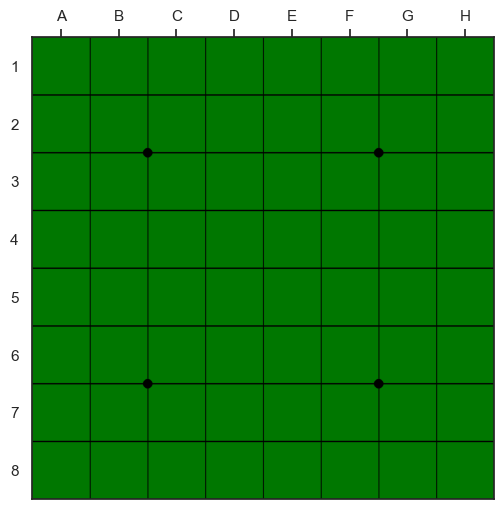

In [ ]:
# 環境の作成
env = othello.make()
env

上記のように、オセロ環境は初期状態ではディスクが配置されていない。ここでも`gymnasium`と同様に`reset`関数を呼び出すことで、ゲーム環境が初期化される。

なお、オセロのプレイヤーや盤の情報などは全て変数`env`の中に`env.player`ならびに`env.board`として格納されており、`gymnasium`と異なっているので注意すること。

In [ ]:
# ゲームのリセット
env.reset()

In [ ]:
print(f'Current player is "{env.player}"')

Current player is "BLACK"


In [ ]:
print(env.board)

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0]
 [ 0  0  0  1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


また、Jupyter Notebook環境においては`env`を表示することで盤面を表わす画像が表示されるようになっている。

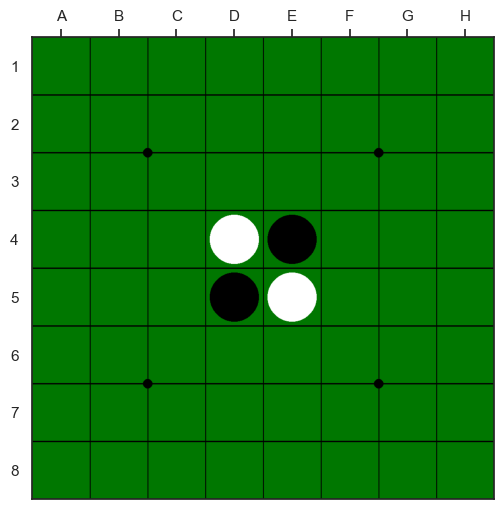

In [ ]:
env

## ランダムな着手

まずは、オセロ環境の仕様を理解するために、白番、黒番ともにランダムに行動させて、どのように状態が変化するかを見てみよう。

`env`には、現在の盤の状態で取ることができる「有効手」の配列を取得する`legal_actions`関数が提供されている。

In [ ]:
# 有効手の列挙
actions = env.legal_actions()
print(actions)

[BLACK 4 C, BLACK 3 D, BLACK 6 E, BLACK 5 F]


上記の出力から、黒番が4行C列、3行D列、6行E列、5行F列の4箇所のいずれかにディスクを置くことができることが分かる。

着手を決定したら、`env.update`関数に手を表す変数を渡すと盤の状態が更新される。

In [ ]:
# 着手して状態を更新
env.update(actions[0])

すると現在の手番のプレイヤーと盤面が更新される。

In [ ]:
print(f'Current player is "{env.player}"')

Current player is "WHITE"


In [ ]:
print(env.board)

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  1  1  0  0  0]
 [ 0  0  0  1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


`env`のJupyter Notebook環境における表示により、黒番が3行5列にディスクを置いたことで、着手したセルがハイライトされて、かつ、盤の状態が正しく更新されていることが確認できる。

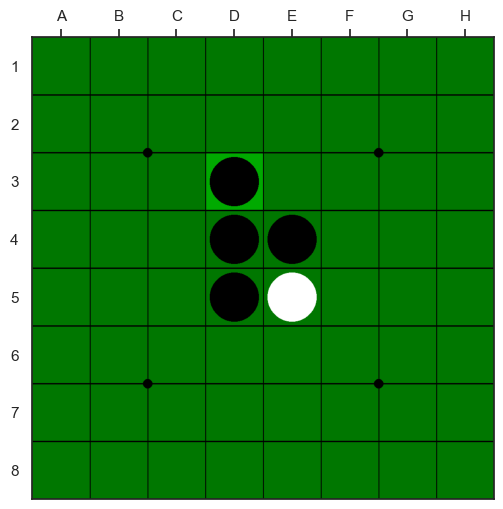

In [ ]:
env

オセロはルール上、着手可能な手がない、すなわちどこにディスクを置いても裏返せる相手方のディスクが存在しない時にはパスをすることになる。

有効手が存在しない時には`legal_actions`が長さが1でパスを表す手を含む配列を返してくる。その手 (`Action`)がパスの手かどうかは`is_pass()`で判定できる。

これらを踏まえて、黒番、白番ともにランダムに着手させて、盤の状態変化を確認する。

In [ ]:
# ゲームのリセット
env.reset()
frames = []

# エピソード開始
while not env.is_done():
    # 現在の状態画像を保存
    img = env.render()
    frames.append(img)

    # 有効手の列挙
    actions = env.legal_actions()

    # 着手可能な手があればランダムに1つを選ぶ
    action = np.random.choice(actions)

    # 着手による盤の状態の更新
    env.update(action)

# 最終状態の画像を保存
img = env.render()
frames.append(img)

In [ ]:
# アニメーションの描画
fig, ax = plt.subplots()
ax.set(xticks=[], yticks=[])

# 各フレームの描画
draw = []
for i, f in enumerate(frames):
    ims = plt.imshow(f)
    draw.append([ims])
    fig.tight_layout()

# アニメーションの作成
ani = ArtistAnimation(fig, draw, interval=100, blit=True)
html = display.HTML(ani.to_jshtml())
display.display(html)

# Matplotlibのウィンドウを閉じる
plt.close()

最終的な状態において、黒番、白番がそれぞれ何個のセルを専有しているかは`count`関数により計算できる。

In [ ]:
print(f"#black: {env.count(Player.BLACK):d}")
print(f"#white: {env.count(Player.WHITE):d}")

#black: 28
#white: 36


最後に、両者ランダムに着手する場合に{glue:}`n_episodes`回対戦すると、どの程度の勝敗になるのかを調べてみる。この際、手番はランダムに黒番と白番 (先攻と後攻)を入れ替えている。

また、ランダム対戦には少々時間がかかるため、以下のコードでは、`joblib`を用いて、並列実行により同時に複数の対局を行なっている。

以下での利便性のため、ランダムに着手する関数として`action_by_random`を作成しておく。

In [ ]:
def action_by_random(env):
    """有効手の中からランダムに手を選ぶ"""
    actions = env.legal_actions()
    return np.random.choice(actions)

In [ ]:
check(action_by_random, action_by_random)
glue("rand_b_win", b_win)
glue("rand_w_win", w_win)
glue("rand_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

52

43

5

:::{admonition} 対局結果: ランダム (#1) vs ランダム (#2)
:class: note

- **プレイヤー#1 勝ち:** {glue:}`rand_b_win`
- **プレイヤー#2 勝ち:** {glue:}`rand_w_win`
- **両者引き分け:** {glue:}`rand_draw`

:::

このようにランダムな着手では当然ながら、勝率はおよそ五分五分になる。以後は、この着手の方法を改良していき、より高い勝率を目指してみる。

:::{admonition} オセロが解けた？
:class: note

2023年10月に「Othello is Solved」という衝撃的なタイトルの論文が、プレプリント投稿サイトのarXivに公開された。この論文は、オセロゲームが「弱解決」したことを示している論文で、「弱解決」とは両対局者が常に最善の手を指し続けると、結果がどうなるかが解析できたことを示す。

人間の体感としては後手の方が(最後にディスクをおけるという意味で)若干有利のように感じるが、この論文によれば、オセロは、**両者が最善手を指し続けると引き分けになる**そうだ。興味のある読者は是非、以下の原著を読んでみてほしい。

Othello is Solved: <https://arxiv.org/abs/2310.19387>
:::

## セル評価値を用いた着手

人間(の初心者)がオセロを指すときに最初に覚えることと言えば、角が取れるように着手を調整する、ということだろう。

角のセルは一度ディスクを置いてしまえば、それ以降、相手に取られることがなく、また縁の領域にあるディスクを一度に多くひっくり返すこともできるため、角にディスクを置くことができれば有利になることが多い。

一方で、角のセルに隣接するセルにディスクを置くと、相手に角を取られる可能性が出てくるので、角に隣接するセルにはできる限りディスクを置かない方が良いことが分かる。

このような人間の経験則に従って、各セルにディスクを置くことが、どのくらい得でどのくらい損なのかを表わす評価値を以下のように定義する。

In [ ]:
SCORE_BOARD = np.array(
    [
        [120, -20, 20, 5, 5, 20, -20, 120],
        [-20, -40, -5, -5, -5, -5, -40, -20],
        [20, -5, 15, 3, 3, 15, -5, 20],
        [5, -5, 3, 0, 0, 3, -5, 5],
        [5, -5, 3, 0, 0, 3, -5, 5],
        [20, -5, 15, 3, 3, 15, -5, 20],
        [-20, -40, -5, -5, -5, -5, -40, -20],
        [120, -20, 20, 5, 5, 20, -20, 120],
    ],
    dtype="float64",
)

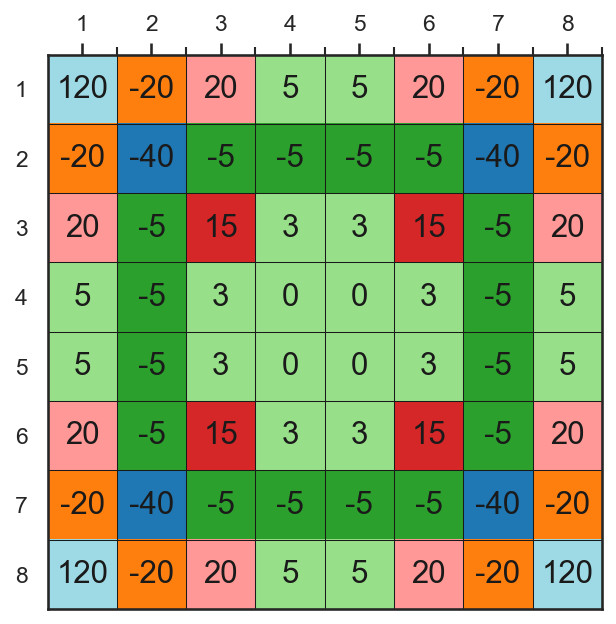

In [ ]:
fig, ax = plt.subplots()

ax.set_xticks(np.arange(0, 8))
ax.set_yticks(np.arange(0, 8))
ax.set_xticklabels(np.arange(1, 9))
ax.set_yticklabels(np.arange(1, 9))

ax.set_xticks(np.arange(1, 9) - 0.5, minor=True)
ax.set_yticks(np.arange(1, 9) - 0.5, minor=True)

ax.imshow(SCORE_BOARD, cmap="tab20", interpolation=None)
for (i, j), z in np.ndenumerate(SCORE_BOARD):
    txt = ax.text(j, i, f"{int(z):d}", ha="center", va="center", color="k", fontsize=15)

ax.grid(which="minor", color="k", linestyle="-", linewidth=0.5)
ax.xaxis.tick_top()

glue("cell_scores", fig)
plt.close()

:::{glue:figure} cell_scores
:figclass: image-stylish sm:w-full md:w-1/2
:name: "オセロ盤のセル評価値"
:::

以下、対戦用にセル評価値に基づいて着手する関数を用意しておく。

In [ ]:
def action_by_score(env):
    """セル評価値を用いた着手"""
    actions = env.legal_actions()

    # パスの場合
    if actions[0].is_pass():
        return actions[0]

    # 各手の評価値を取得
    scores = [SCORE_BOARD[action.x, action.y] for action in actions]
    return actions[np.argmax(scores)]

このルーチンを用いて、先ほどと同様に{glue:}`n_episodes`回の対戦を行ない、ランダムな着手に比べて、どのくらい勝率が上昇するかを見てみよう。

In [ ]:
check(action_by_score, action_by_random)
glue("score_b_win", b_win)
glue("score_w_win", w_win)
glue("score_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

85

13

2

:::{admonition} 対局結果: セル評価値 (#1) vs ランダム (#2)
:class: note

- **プレイヤー#1 勝ち:** {glue:}`score_b_win`
- **プレイヤー#2 勝ち:** {glue:}`score_w_win`
- **両者引き分け:** {glue:}`score_draw`

:::

上記の通り、人間の経験則を導入することでランダムに着手するのと比べて大幅に勝率が上昇していることが分かる。

(ssec:minimax)=
## ミニマックス探索

上記のセル評価値に基づく着手では、今まさに打とうとしている手が、**その時点においてどのくらいの価値を持つのか**だけを考慮していた。

しかし、実際には、局面によっては、角に単にセルの評価値が高いディスクに置くよりも、その後、何手か指した後に、より勝ちの高い手が打てるような手も存在するだろう。

実際に人間がオセロをプレイするときも、ある程度は「次に相手が何を」してくるかを考えているはずである。

説明を分かりやすくするために、黒番の手を探索することとすると、次のような前提が考えられる。

- 黒の手番では、手を指した後の盤面の「黒にとっての」評価値が**最大**になるように指す (自分に取って得な手を指す)
- 白の手番では、手を指した後の盤面の「黒にとっての」評価値が**最小**になるように指す (相手に取って損な手を指す)

このような考え方に基づいて、手を先読みして着手を探索する手法が**ミニマックス探索**である (min-max探索ではないので注意)。

ミニマックス探索においては、一定手数先の盤面を読んだら、その盤面を何からの評価関数で評価する必要がある。

今回は、前述の盤面評価値を用いて「(自分の評価値) - (相手の評価値)」を、その盤面の評価値とする。

In [ ]:
def score_fn(env, current_player):
    """
    current_playerにとっての評価値を返す
    """
    if current_player.is_black():
        return np.sum(env.board * SCORE_BOARD)
    elif current_player.is_white():
        return -np.sum(env.board * SCORE_BOARD)
    else:
        raise ValueError("Invalid player")

ミニマックス探索を行う`minimax`関数では、以下の3つの場合を考える。

1. 探索を終了する深さに到達するか、ゲームが終了している
2. 探索中の手番が「現在の手番」と同じ色である
3. 探索中の手番が「相手の手番」と同じ色である

1のケースは、これ以上先の手を探索しないので、前述の`score_fn`を用いて盤面を評価する。この際、ミニマックス探索における盤面の評価値は、常に**現在の手番に対する評価値**であることに注意してほしい。

2のケースは自分の手番であるので、次の手を指したときに、盤面の評価値が**最大**になるような手を指すのが自然である。従って、着手後に再帰的に`minimax`関数を呼び出し、得られる評価値の最大値を盤面の評価値とすれば良い。

3のケースは相手の手番であるので、次の手を指したときに、盤面の評価値が**最小**になるような手を指すのが自然である。従って、着手後に再帰的に`minimax`関数を呼び出して、得られる評価値の最小値を盤面の評価値とする。

この考え方を元に実装した`minimax`関数は次のようになる。

In [ ]:
def minimax(env, current_player, depth):
    """
    current_playerにとって一番都合が良いスコアを返す
    """

    if env.is_done() or depth == 0:
        # ゲームが終了しているか、深さが0に達したら評価値を返す
        return score_fn(env, current_player)

    # 現在の手番によって最大を取るか、最小を取るかを切り替える
    actions = env.legal_actions()
    if env.player == current_player:
        # 現在の手番が自分なら最大値を取る
        best_score = -np.inf
        for action in actions:
            env.update(action)
            v = minimax(env, current_player, depth - 1)
            env.undo()
            best_score = max(best_score, v)
    else:
        # 現在の手番が相手なら最小値を取る
        best_score = np.inf
        for action in actions:
            env.update(action)
            v = minimax(env, current_player, depth - 1)
            env.undo()
            best_score = min(best_score, v)

    return best_score

以下、対戦用にミニマックス探索に基づく着手を関数化しておく。

In [ ]:
def action_by_minimax(env, depth=2):
    """ミニマックス法に基づく着手"""

    # 現在の手番を一次変数に保存
    current_player = env.player
    actions = env.legal_actions()

    # 最善の手を探索する
    best_score = -np.inf
    best_action = actions[0]
    for action in actions:
        env.update(action)
        v = minimax(env, current_player, depth)
        env.undo()

        if best_score < v:
            best_score = v
            best_action = action

    return best_action

In [ ]:
check(action_by_minimax, action_by_random)
glue("minimax_b_win", b_win)
glue("minimax_w_win", w_win)
glue("minimax_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

90

8

2

結果は以下の通りで、ミニマックス探索で2手先を読むだけで飛躍的に勝率が上昇していることが分かる。

:::{admonition} 対局結果: ミニマックス探索 (#1) vs ランダム (#2)
:class: note

- **プレイヤー#1 勝ち:** {glue:}`minimax_b_win`
- **プレイヤー#2 勝ち:** {glue:}`minimax_w_win`
- **両者引き分け:** {glue:}`minimax_draw`

:::

一方で、ミニマックス探索は現在の手番と探索中の盤面の手番の関係によって、盤面評価値の最大値を取るか最小値を取るかを切り替える必要があり、やや実装が複雑である。

このような実装上の問題を解決したのが**ネガマックス探索**であり、ミニマックス探索と同様の探索をより簡易なコードで実現することができる。詳細については解説した書籍やウェブページが多数存在するのでそちらを参照してほしい。

::::{admonition} 問
:class: question

ミニマックス探索の実装を改善したネガマックス探索について調査し、実際に実装した上で、コード上、性能上の違いについて考察せよ。

::::

(ssec:alpha-beta)=
## アルファベータ探索

ミニマックス探索は**再帰的に全ての手を評価する**ため、より多くの手を読もうとすると、かなり多くの時間を要する。実際、ミニマックス探索は**これまでの探索で見つかった最善手よりも悪い手**も探索しているがために、余計な計算を行なっている。

以下では、[Wikipedia](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning)に掲載されている以下のゲーム木を用いて、アルファベータ探索の原理について見てみる。

:::{image} https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/AB_pruning.svg/1920px-AB_pruning.svg.png
:alt: alpha-beta-pruning
:align: center
:class: image-stylish
:::

今、手番のプレイヤーには3つの合法手があり、それらを再帰的に探索していく。最もアルファベータ探索の意味が分かりやすいのは二段目・一番右の「5」のノードを探索した場合だろう。

アルファベータ探索は深さ優先探索の一種なので、この「5」のノードを探索する時点では既に、二段目の「3」、「6」のノードは探索済みでその評価値が分かっている。

この「3」、「6」のノードは自分の手を指した後の盤面の評価値であるので、この最大値を取るのがミニマックス探索であった。従って、現在分かっている最善の手の評価値は「6」である。

ここで、二段目・一番右の「5」と書かれたノードを探索する。なお、この時点では、このノードの評価値が「5」であることは分かっていない。

二段目・一番右の「5」のノードには2つの子ノードが接続されており、三段目・右から2番目の「5」のノードを先に探索していく。すると、そこに書かれた通り、三段目・左から2番目のノードの評価値は「5」であると分かる。

この際、三段目の子ノードの評価値は相手の手番の評価値なので、最小値が取られる。従って、二段目・一番右の評価値が「5」を超えることがないことがこの時点で確定する。

すると、二段目のノードの最大評価値を持つ二段目・中央の「6」のノードの評価値を、二段目・一番右の「5」のノードの評価値が超えることがなくなるので、三段目の以後のノードは探索する必要がないのである。

このように、探索の過程における自分の手番における最大の評価値と、相手の手番における「自分にとっての」最小の評価値を、それぞれ**アルファ値**、**ベータ値**と呼ぶ。

探索の過程でアルファ値は単調増加し、ベータ値は単調減少していく。最初、アルファ値はベータ値より小さいが、その大小関係が逆転した場合には探索を打ち切って良い。

特に、自分の手番の探索中にアルファ値が上昇し、ベータ値を上回ったケースをベータ・カットと呼び、相手の手番を探索中にベータ値が減少し、アルファ値を下回ったケースをアルファ・カットと呼ぶ。

これらの議論を元に実装したアルファベータ探索の関数`alpha_beta`は次のようになる。

In [ ]:
def alpha_beta(env, current_player, depth, alpha=-np.inf, beta=np.inf):
    """
    current_playerにとって一番都合が良いスコアを返す
    """

    if env.is_done() or depth == 0:
        # ゲームが終了しているか、深さが0に達したら評価値を返す
        return score_fn(env, current_player)

    # 現在の手番によって最大を取るか、最小を取るかを切り替える
    actions = env.legal_actions()
    if env.player == current_player:
        # 現在の手番が自分ならアルファを更新
        for action in actions:
            env.update(action)
            v = alpha_beta(env, current_player, depth - 1, alpha, beta)
            env.undo()
            alpha = max(alpha, v)
            # ベータカット
            if alpha >= beta:
                break

        return alpha

    else:
        # 現在の手番が相手ならベータを更新
        for action in actions:
            env.update(action)
            v = alpha_beta(env, current_player, depth - 1, alpha, beta)
            env.undo()
            beta = min(beta, v)
            # アルファ・カット
            if alpha >= beta:
                break

        return beta

また、上記の`alpha_beta`関数を用いて着手する関数は次のようになる。

In [ ]:
def action_by_alpha_beta(env, depth=2):
    """アルファベータ法に基づく着手"""

    current_player = env.player
    actions = env.legal_actions()

    best_score = -np.inf
    best_action = actions[0]
    for action in actions:
        env.update(action)
        v = alpha_beta(env, current_player, depth)
        env.undo()

        if best_score < v:
            best_score = v
            best_action = action

    return best_action

では、アルファベータ探索の性能を確かめるために、ミニマックス探索と対戦させてみる。結果は次のようになる。

In [ ]:
check(action_by_alpha_beta, action_by_minimax)
glue("ab_vs_minimax_b_win", b_win)
glue("ab_vs_minimax_w_win", w_win)
glue("ab_vs_minimax_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

60

40

0

:::{admonition} 対局結果: アルファベータ探索 (#1) vs ミニマックス探索 (#2)
:class: note

- **プレイヤー#1 勝ち:** {glue:}`ab_vs_minimax_b_win`
- **プレイヤー#2 勝ち:** {glue:}`ab_vs_minimax_w_win`
- **両者引き分け:** {glue:}`ab_vs_minimax_draw`

:::

この結果を見ると、アルファベータ探索はミニマックス探索と比べて有意に強くなっていない。これは、アルファベータ探索はあくまでミニマックス探索を効率化したものであるからで、探索の深さが変わらない場合には強さも変化しない。

次項では、アルファベータ探索の効率を活かすために、適応的に探索の深さを変更する手法を見てみる。

(ssec:iterative-deepening)=
## 反復深化

これまでのミニマックス探索やアルファベータ探索の実装では、探索する深さを固定していた。

しかし、実際には深さが同じでも、たくさんの手を読まなければならない盤面もあれば、**特にゲームの終盤のように**ほとんど手を読まなくても良い盤面もある。

従って、同じ時間だけ考慮して良いのであれば、探索する手の深さを固定することはあまり効率的とは言えない。

そこで、深さ0 (自分の現在の手だけを読む)からスタートして、時間の許す限り深さを徐々に深くしていくような戦略を考える。このような戦略を**反復深化** (iterative deepening)と呼ぶ。

この戦略を前述の`action_by_minimax`と`action_by_alpha_beta`に単純に組み込むとすると、次のようになるだろう。

In [ ]:
def action_by_minimax_deepen(env, time_limit=1.0e-2):
    """反復深化版ミニマックス法"""

    current_player = env.player
    actions = env.legal_actions()

    # 探索の深さは0からスタートする
    max_depth = 0

    # 手を読む時間を計測する
    start_time = time.perf_counter()
    best_action = actions[0]

    # 時間が許す限り探索を続ける
    while time.perf_counter() - start_time < time_limit:
        # 深さが増えるごとに、その深さで最善の手を最善みなす
        best_score = -np.inf
        for action in actions:
            env.update(action)
            v = minimax(env, current_player, max_depth)
            env.undo()

            if best_score < v:
                best_score = v
                best_action = action

        # 探索する深さを増やす
        max_depth += 1

    return best_action

In [ ]:
def action_by_alpha_beta_deepen(env, time_limit=1.0e-2):
    """反復深化版アルファベータ法"""

    current_player = env.player
    actions = env.legal_actions()

    max_depth = 0
    best_action = actions[0]
    start_time = time.perf_counter()
    while time.perf_counter() - start_time < time_limit:
        best_score = -np.inf
        for action in actions:
            env.update(action)
            v = alpha_beta(env, current_player, max_depth)
            env.undo()

            if best_score < v:
                best_score = v
                best_action = action

        max_depth += 1

    return best_action

なお、上記の実装において、深さを深くした際には同じ曲面を再度探索しなければならないので、やや非効率に感じるかもしれない。

しかし、再探索にかかる計算コストは多くの場合、それほど多くないため、このような実装で十分に計算時間内で良い手を見つけることができる。

なお、再探索を完全に防ぎたい場合には、探索済みの手をハッシュする置換表 (transposition table)を用いる方法もあり、十分に長い時間を考慮に使える場合には有効になるだろう。

In [ ]:
check(action_by_alpha_beta_deepen, action_by_minimax_deepen)
glue("ab_vs_minimax_deepen_b_win", b_win)
glue("ab_vs_minimax_deepen_w_win", w_win)
glue("ab_vs_minimax_deepen_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

87

13

0

反復深化を取り入ればアルファベータ探索とミニマックス探索の対戦結果は次の通りであり、同じ探索時間ではアルファベータ探索の方が圧倒的に強く、より多くの局面を探索できていることが確認できる。

:::{admonition} 対局結果: 反復深化アルファベータ (#1) vs 反復深化ミニマックス (#2)
:class: note

- **プレイヤー#1 勝ち:** {glue:}`ab_vs_minimax_deepen_b_win`
- **プレイヤー#2 勝ち:** {glue:}`ab_vs_minimax_deepen_w_win`
- **両者引き分け:** {glue:}`ab_vs_minimax_deepen_draw`

:::

(ssec:monte-carlo)=
## 原始モンテカルロ探索

ここまでに紹介したミニマックス法やアルファベータ法は、現在の状態に対して何らかの評価値が既に与えられている場合には有効であるものの、このような評価値を**どのように決定すれば最適なのか**は実際のところ難しい。

特に上記の例では、オセロ盤の状態ではなく、セルに対して評価値を与えているが、実際のオセロにおいて、どのセルにディスクを置けばより勝ちに近づくかは、そのときに既に置かれているディスクに依存するだろう。

従って、ここまでのセルの評価値に基づく探索には限界があり、**実際に勝てるのかどうか**に基づいた着手を目指す必要があると分かる。しかし、勝ち負けを知るためにはオセロを終局までプレイしなければならない。では、その過程ではどのような手を指せば良いだろうか。

**原始モンテカルロ探索**は、モンテカルロ法、すなわちランダムな着手によって、今の**オセロ盤の状態がどの程度、勝ちやすい、負けやすい状態なのかを近似的に推測しながら着手する手法**である。言い換えれば、どのような手が良いのかは一旦おいておいて、**適当に指しても勝ちやすければ、それが勝ちやすい局面**と見なして着手を決定する。

今、とあるオセロの局面を考えたとき、着手できる手は通常複数ある。このような複数の手をランダムに指して、どの手がより勝ちに近づくかを推定するのだが、この問題は、まさに**多腕バンディット問題**と同様の問題であることが分かる。多腕バンディット問題においては、どのスロットアームを回すかを最適化していたが、今回はオセロの有効手に対して同様の操作を行なう。

まず、とある局面からランダムにプレイを行なって終局まで進める操作を関数として定義しておく。このような操作を**プレアウト**と呼ぶ。

In [ ]:
def playout(env):
    """ランダムに着手して終局まで進める"""
    while not env.is_done():
        actions = env.legal_actions()
        action = random.choice(actions)
        env.update(action)

この関数を呼び出して、とある局面を終局まで進めたとき、今の手番のプレイヤーが勝ちなら **+1点** の報酬を得ることとする。

プレイアウトをするべき手は多腕バンディット問題において、良い性能であったUCB1値を用いて選択する。UCB1値の定義を再掲しておく。

$$
  \text{UCB1}_i = \frac{v_i}{n_i} + \sqrt{\frac{2 \log N}{n_i}}
$$

この定義は多腕バンディット問題の時と若干表記が異なっているが、式中の各記号は次の通り。

- $v_i$: $i$ 番目の候補手を指してプレイアウトした時の評価値の合計
- $n_i$: $i$ 番目の候補手に対してプレイアウトを実施した回数
- $N$: 全ての候補手に対するプレイアウト数の合計

以下、UCB1値は定義上、$n_i$ 即ち、各候補手に対するプレイアウト回数が1回以上でないと計算できないので、UCB1を用いた原始モンテカルロ法においては、

1. 各候補手に対して1回ずつプレイアウトを実行
1. 以下、UCB1値を計算し、その値が最大の候補手に対してプレイアウトを実行

という流れでどの候補手が最も勝ちやすいのかを推測していく。

このプレイアウト操作を制限時間内でできる限り実行したら、プレイアウトされた回数が最大の手が最適な手であると判断する。プレイアウトされた回数が最大である、ということは、UCB1値を用いた探索において、最も有望な手であるということに留意している。

In [ ]:
def action_by_monte_carlo(env, time_limit=1.0e-2):
    """
    原始モンテカルロ法に基づく着手
    """

    player = env.player
    actions = env.legal_actions()
    values = np.zeros(len(actions))
    n_checks = np.zeros(len(actions))
    start_time = time.perf_counter()

    # 制限時間内でプレイアウトを繰り返す
    n_trials = 0
    while time.perf_counter() - start_time < time_limit:
        n_trials += 1

        # まだ調べていない手があるときはその手を調べる
        # (そうしないとUCB1値が計算できないため)
        action_idx = -1
        for i, n in enumerate(n_checks):
            if n == 0:
                action_idx = i
                break
        else:
            # 全ての有効手を最低1回調べたら、UCB1値に基づいて着手
            ucb1_values = [
                v / n + np.sqrt(2.0 * np.log(n_trials) / n) for v, n in zip(values, n_checks)
            ]
            action_idx = np.argmax(ucb1_values)

        # 手を進めてプレイアウトする
        env_cpy = env.copy()
        env_cpy.update(actions[action_idx])
        playout(env_cpy)

        # UCB1値計算用のチェック回数と評価値を更新
        n_checks[action_idx] += 1.0
        if env_cpy.is_win(player):
            values[action_idx] += 1.0
        elif env_cpy.is_lose(player):
            values[action_idx] -= 1.0

    # プレイアウト回数が最大の手を返す
    return actions[np.argmax(n_checks)]

では、原始モンテカルロ法の性能を評価するため、先ほどの反復深化版アルファベータ探索と対戦させてみる。着手に用いる制限時間は、どちらも100分の1秒とする。

すると結果は次のようになる。

In [ ]:
check(action_by_monte_carlo, action_by_alpha_beta_deepen)
glue("mc_vs_alpha_beta_b_win", b_win)
glue("mc_vs_alpha_beta_w_win", w_win)
glue("mc_vs_alpha_beta_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

66

33

1

:::{admonition} 対局結果: 原始モンテカルロ (#1) vs アルファベータ探索 (#2)
:class: note

- **プレイヤー#1 勝ち:** {glue:}`mc_vs_alpha_beta_b_win`
- **プレイヤー#2 勝ち:** {glue:}`mc_vs_alpha_beta_w_win`
- **両者引き分け:** {glue:}`mc_vs_alpha_beta_draw`

:::

興味深いことに、盤面評価関数などの人間の前提知識に基づかない原始モンテカルロ法がアルファベータ探索と同等か、それ以上の性能を示す。

これらの手法の強さは探索に使える考慮時間の長さによっても変化するものの、ランダムなプレイアウトに基づく盤面の評価が非常に強力であることが分かる。

(ssec:monte-carlo-tree-search)=
## モンテカルロ木探索

原始モンテカルロの弱点は、**自分の候補手に対してしか有望な手を考えていない**という点にある。原始モンテカルロにおいては、自分が候補手を指したあとは**自分も相手もランダムに着手する**と仮定しているが、実際の対局においては、自分も相手も、より勝ちやすい手を指すのが普通だろう。

**モンテカルロ木探索**は、上記の問題を解決するために、自分に対しても相手に対しても原始モンテカルロ同様にUCB1値に基づいて最善手を推定する手法である。

ここで「木探索」という用語が出てくるが、モンテカルロ木探索では[ゲーム木](https://ja.wikipedia.org/wiki/%E3%82%B2%E3%83%BC%E3%83%A0%E6%9C%A8)と呼ばれる木構造の中で手を探索する。ゲーム木では「局面を表すノード」が「その局面における候補手を指すことで得られる次局面を表すノード」とツリー状に接続されている。

UCB1値を使って候補手の探索を行なう場合、この木構造を特に**UCT** (Upper Confidence Tree)と呼ぶ。

### モンテカルロ木探索に基づく着手関数

モンテカルロ木探索に用いるUCTのノードを`UctNode`として実装したとしよう。

この場合、モンテカルロ木探索に基づく着手関数`action_by_mcts`では、時間の許す限りUCTの根ノードの評価を繰り返すことになる。

UCTのノードを評価すると、必要に応じてゲーム木のさらに先の手を展開しながら盤面の評価を行っていく。

UCTの各ノードはUCB1値に基づいて探索されるので、一番有望と考えられる手は、最も多く探索された子ノードであると考えられる。

これらの考えを用いると`action_by_mcts`は次のようなコードとなる。

In [ ]:
def action_by_mcts(env, time_limit=1.0e-2):
    """
    モンテカルロ木探索に基づく着手
    """

    # ノードと直接の子ノードの作成
    root_node = UctNode(env)
    root_node.expand_child_nodes()

    # 時間の許す限り根ノードの評価を繰り返す
    start_time = time.perf_counter()
    while time.perf_counter() - start_time < time_limit:
        root_node.evaluate()

    # 最も評価回数の多いノードを選ぶ
    n_evals = [node.n_check for node in root_node.child_nodes]
    actions = env.legal_actions()
    return actions[np.argmax(n_evals)]

### UCTノードの評価

次にモンテカルロ木探索において中心的な役割を担う`UctNode`クラスの実装について見ていこう。

UCTノードにおいてノードの評価値を更新する`evaluate`関数が呼ばれたら、次のような手順で各盤面に対応するノードを評価する。

1. ゲーム終了に対応するノードなら、勝敗に基づいて評価する
1. ノードの評価回数が十分でなければプレイアウトにより評価する
1. ノードの評価回数が一定以上なら、子ノードを展開し、そのUCB1値に基づいて再帰的に`evaluate`関数を呼び出す

これらの方法で得られた評価値(`UctNode.value`)とそのノードの評価回数(`UctNode.n_check`)を各ノードに保存しておく。

このようにして、とあるノードの全ての子ノードが一度以上評価されたら、次に子ノードに対応する、どの手を探索すべきかはUCB1値を元に決定できる。この子ノードの選択関数が`choose_next_action`である。

これらを踏まえた`evaluate`関数の実装は以下のようになる。

```python
def evaluate(self):
    """
    現在の盤に対する最善手を探索し、評価値を算出
    """
    value = 0.0

    if self.env.is_done():
        # ゲーム終了なら勝敗に応じて報酬を返す
        if self.env.is_win(self.player):
            value = 1.0
        elif self.env.is_lose(self.player):
            value = -1.0
        else:
            value = 0.0

    elif len(self.child_nodes) == 0:
        # 評価回数が不十分ならプレイアウトをして報酬を計算
        value = self.playout()

    else:
        # 子ノードがあればUCB1値に基づいて相手の手を選択・評価
        # 子ノードの評価値は相手の手番の評価値なので、符号を逆にする
        value = -1.0 * self.choose_next_action().evaluate()

    # ノードの状態を更新する
    self.value += value
    self.n_check += 1.0

    # チェック回数が十分になったら子ノードを展開する
    if self.n_check >= self.N_VALID_CHECKS:
        if len(self.child_nodes) == 0:
            self.expand_child_nodes()

    return value
```

::::{admonition} モンテカルロ木探索のポイント①
:class: note

モンテカルロ木探索のポイントは、`evaluate`関数はプレイアウトを含む盤面の評価を行って探索の精度を高めることである。一方で、着手の際には`evaluate`による探索によって最も探索されたノードが有望な着手であると判断する。

::::

### 子ノードの展開

モンテカルロ木探索では、次に探索する子ノードを探索した数に基づいて次に着手を決定するのだが、そのためには、各子ノードの勝率を含むUCB1値が盤面の有望さを反映していなければならない。

一方で、探索の途中で初めて見る盤面が出てきたときには、その次の手のUCB1値はすぐに計算できず、かといって、UCB1値を計算するために子ノードでプレイアウトを実施するのも効率的とは言いがたい。

そこで、始めて見る盤面が現れた時には、そもそも**その盤面がある程度勝ちやすいと判断してから、子ノードを展開して、さらに先の手を読むのが良い**だろう。

この際、その盤面が勝ちやすいと判断できる指標が評価回数である。子ノードの評価は常にUCB1値を用いて行っていくので、有望なノードほど評価回数が多くなる。

この考えに従って、前述の`evaluate`関数における子ノードの展開は、そのノードのチェック回数が`N_VALID_CHECKS`を超えた場合に限り、そうでない場合には、ランダムなプレイアウトにより評価値を決定する。

### 子ノードの選択

プレイアウトによる評価回数が十分になったら、子ノードの評価値に基づいて、そのノードを更に評価していく。

この際、評価に使う子ノードはUCB1値を用いるが、そもそもUCB1値は全ての選択肢が一度以上評価されていないと計算できない。

そこで、以下の`choose_child_node`関数では、未評価のノードが存在する場合には、そのノードを選択し、全ての子ノードが探索済みの場合には、UCB1値に基づく子ノードの選択を行う。

この際、とあるノードの評価値を考える際、**子ノードの評価値は相手にとっての評価値なので、平均評価値の符号を逆転させる必要がある**ことに注意してほしい。

```python
def choose_child_node(self):
    """
    次に探索する子ノードを選択する
    """

    # 評価回数が0回のノードがあったら、それを返す
    # (そうしないとUCB1値が計算できない)
    for node in self.child_nodes:
        if node.n_check == 0:
            return node

    # 子ノードの総評価回数 (UCB1値の評価に用いる)
    t = np.sum([node.n_check for node in self.child_nodes])

    # 各ノードのUCB1値の計算
    # 子ノードの評価値は相手の手番の評価値なので、平均勝率の符号が逆になる
    ucb1_values = [
        (-node.value / node.n_check) + np.sqrt(2.0 * np.log(t) / node.n_check)
        for node in self.child_nodes
    ]
    return self.child_nodes[np.argmax(ucb1_values)]
```

::::{admonition} モンテカルロ木探索のポイント②
:class: note

手の探索中に始めて見る局面が現れたら、その局面が親ノードから見たUCB1値に基づいて一定回数評価された時点で有望な局面であると見なし、子ノードを展開する。

まだ有望な局面であると判断できない場合には、ランダムなプレイアウトによりノードを評価する。

::::

### UCTノードの実装例

以上を踏まえたUCTノードの実装例を以下に示す。なお、やや長いコードになるのため、最初の時点ではコードは非表示にしてある。

In [ ]:
class UctNode(object):
    """
    UCB1値を用いた子ノードの探索を行うノード
    """

    # 子ノードを展開するまでのチェック回数
    N_VALID_CHECKS = 10

    def __init__(self, env):
        self.player = env.player
        self.env = env.copy()
        self.n_check = 0.0
        self.value = 0.0
        self.child_nodes = []

    def evaluate(self):
        """
        現在の盤に対する最善手を探索し、評価値を算出
        """
        value = 0.0

        if self.env.is_done():
            # ゲーム終了なら勝敗に応じて報酬を返す
            if self.env.is_win(self.player):
                value = 1.0
            elif self.env.is_lose(self.player):
                value = -1.0
            else:
                value = 0.0

        elif len(self.child_nodes) == 0:
            # 評価回数が不十分ならプレイアウトをして報酬を計算
            value = self.playout()

        else:
            # 子ノードがあればUCB1値に基づいて相手の手を選択・評価
            # 子ノードの評価値は相手の手番の評価値なので、符号を逆にする
            value = -1.0 * self.choose_child_node().evaluate()

        # ノードの状態を更新する
        self.value += value
        self.n_check += 1.0

        # チェック回数が十分になったら子ノードを展開する
        if self.n_check >= self.N_VALID_CHECKS:
            if len(self.child_nodes) == 0:
                self.expand_child_nodes()

        return value

    def playout(self):
        """
        ランダムにプレイアウトをして評価値を取得
        """

        env_cpy = self.env.copy()
        while not env_cpy.is_done():
            actions = env_cpy.legal_actions()
            action = np.random.choice(actions)
            env_cpy.update(action)

        if env_cpy.is_win(self.player):
            return 1.0
        elif env_cpy.is_lose(self.player):
            return -1.0
        else:
            return 0.0

    def expand_child_nodes(self):
        """
        次の候補手に対応する子ノードを作成する
        """

        actions = self.env.legal_actions()
        for a in actions:
            self.env.update(a)
            new_node = UctNode(self.env)
            self.child_nodes.append(new_node)
            self.env.undo()

    def choose_child_node(self):
        """
        次に探索する子ノードを選択する
        """

        # 評価回数が0回のノードがあったら、それを返す
        # (そうしないとUCB1値が計算できない)
        for node in self.child_nodes:
            if node.n_check == 0:
                return node

        # 子ノードの総評価回数
        t = np.sum([node.n_check for node in self.child_nodes])

        # UCB1値の計算
        # 子ノードの評価値は相手の手番の評価値なので、平均勝率の符号が逆になる
        ucb1_values = [
            (-node.value / node.n_check) + np.sqrt(2.0 * np.log(t) / node.n_check)
            for node in self.child_nodes
        ]
        return self.child_nodes[np.argmax(ucb1_values)]

以上が、モンテカルロ木探索の全体像であるが、再帰的な探索など、やや高度な内容を含むので、何度もコードと解説を読み直して理解に努めてみてほしい。

では、このモンテカルロ木探索をアルファベータ探索と対戦させて、実力を確かめてみよう。

In [ ]:
check(action_by_mcts, action_by_alpha_beta_deepen)
glue("mcts_vs_alpha_beta_b_win", b_win)
glue("mcts_vs_alpha_beta_w_win", w_win)
glue("mcts_vs_alpha_beta_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

35

54

11

:::{admonition} 対局結果: モンテカルロ木探索 (#1) vs アルファベータ探索 (#2)
:class: note

- **プレイヤー#1 勝ち:** {glue:}`mcts_vs_alpha_beta_b_win`
- **プレイヤー#2 勝ち:** {glue:}`mcts_vs_alpha_beta_w_win`
- **両者引き分け:** {glue:}`mcts_vs_alpha_beta_draw`

:::

上記の通り、相手の手や、その後に続く自分の手に対してもUCB1値に基づく有望手の推定を行なうことで、アルファベータ探索と同程度の強さを実現することができた。

なお、現在の考慮時間である100分の1秒は、それほど長い時間ではないため、モンテカルロ木探索を用いる場合には十分にその性能を発揮することが難しい。

実際、モンテカルロ木探索と原始モンテカルロを対戦させてみると、原始モンテカルロの方が良い性能を示す。

In [ ]:
check(action_by_mcts, action_by_monte_carlo)
glue("mcts_vs_mc_b_win", b_win)
glue("mcts_vs_mc_w_win", w_win)
glue("mcts_vs_mc_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

23

76

1

:::{admonition} 対局結果: モンテカルロ木探索 (#1) vs 原始モンテカルロ (#2)
:class: note

- **プレイヤー#1 勝ち:** {glue:}`mcts_vs_mc_b_win`
- **プレイヤー#2 勝ち:** {glue:}`mcts_vs_mc_w_win`
- **両者引き分け:** {glue:}`mcts_vs_mc_draw`

:::

この関係性が逆転するのはCPUの性能にもよるが、概ね考慮時間を1秒以上とした場合であるので、自信のコンピュータでより長い考慮時間を設定して、その性能を比較してみてほしい。

## まとめ

最後に、モンテカルロ木探索とアルファベータ探索を1手1秒ずつ考慮させて対戦した際の様子を示す。

一番最初に示したランダムvsランダムの対局と比べると、アルファベータ探索は盤面評価に基づいて積極的に角を取りに行く一方で、モンテカルロ木探索は、終端状態で価値に繋がるような手を指すように努めている様子が分かる。

In [ ]:
# ゲームのリセット
env.reset()
frames = []

# エピソード開始
progress = tqdm(total=60)
while not env.is_done():
    # 現在の状態画像を保存
    img = env.render()
    frames.append(img)

    if env.player.is_black():
        action = action_by_mcts(env, time_limit=1.0)
    elif env.player.is_white():
        action = action_by_alpha_beta_deepen(env, time_limit=1.0)
    else:
        raise ValueError("Invalid player")

    # 着手による盤の状態の更新
    env.update(action)
    progress.update(1)

# 最終状態の画像を保存
img = env.render()
frames.append(img)

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
# アニメーションの描画
fig, ax = plt.subplots()
ax.set(xticks=[], yticks=[])

# 各フレームの描画
draw = []
for i, f in enumerate(frames):
    ims = plt.imshow(f)
    draw.append([ims])
    fig.tight_layout()

# アニメーションの作成
ani = ArtistAnimation(fig, draw, interval=100, blit=True)
html = display.HTML(ani.to_jshtml())
display.display(html)

# Matplotlibのウィンドウを閉じる
plt.close()

::::{admonition} 問
:class: question

原始モンテカルロ探索やモンテカルロ木探索において、プレイアウトする手の選択方法をUCB1値でない方法 ($\varepsilon$-greedy法やソフトマックス探索)に置き換えた時、オセロAIの強さはどの程度変化するか調べよ。

::::

::::{admonition} 問
:class: question

これまでに紹介したゲームAIについて、考慮時間を1秒に設定したときの性能を評価せよ。

なお、`action_by_xxxx`関数において、評価時間だけを変更したい場合には`functools`モジュールの`partial`を用いて`partial(action_by_xxxx, time_limit=1.0)`のように書けば良い。

::::